### IMPORTS

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

C:\Users\91897\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### DATA PREPARATION 

In [2]:
IMAGE_SIZE=224
BATCH_SIZE=32

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names=dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)

# It is in 68 batches . Each batch has 32 items....

501

In [6]:
for image_batch , label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[9 3 9 2 4 3 8 7 7 7 1 9 0 2 2 4 5 0 2 1 3 7 4 7 5 4 5 4 6 1 0 7]


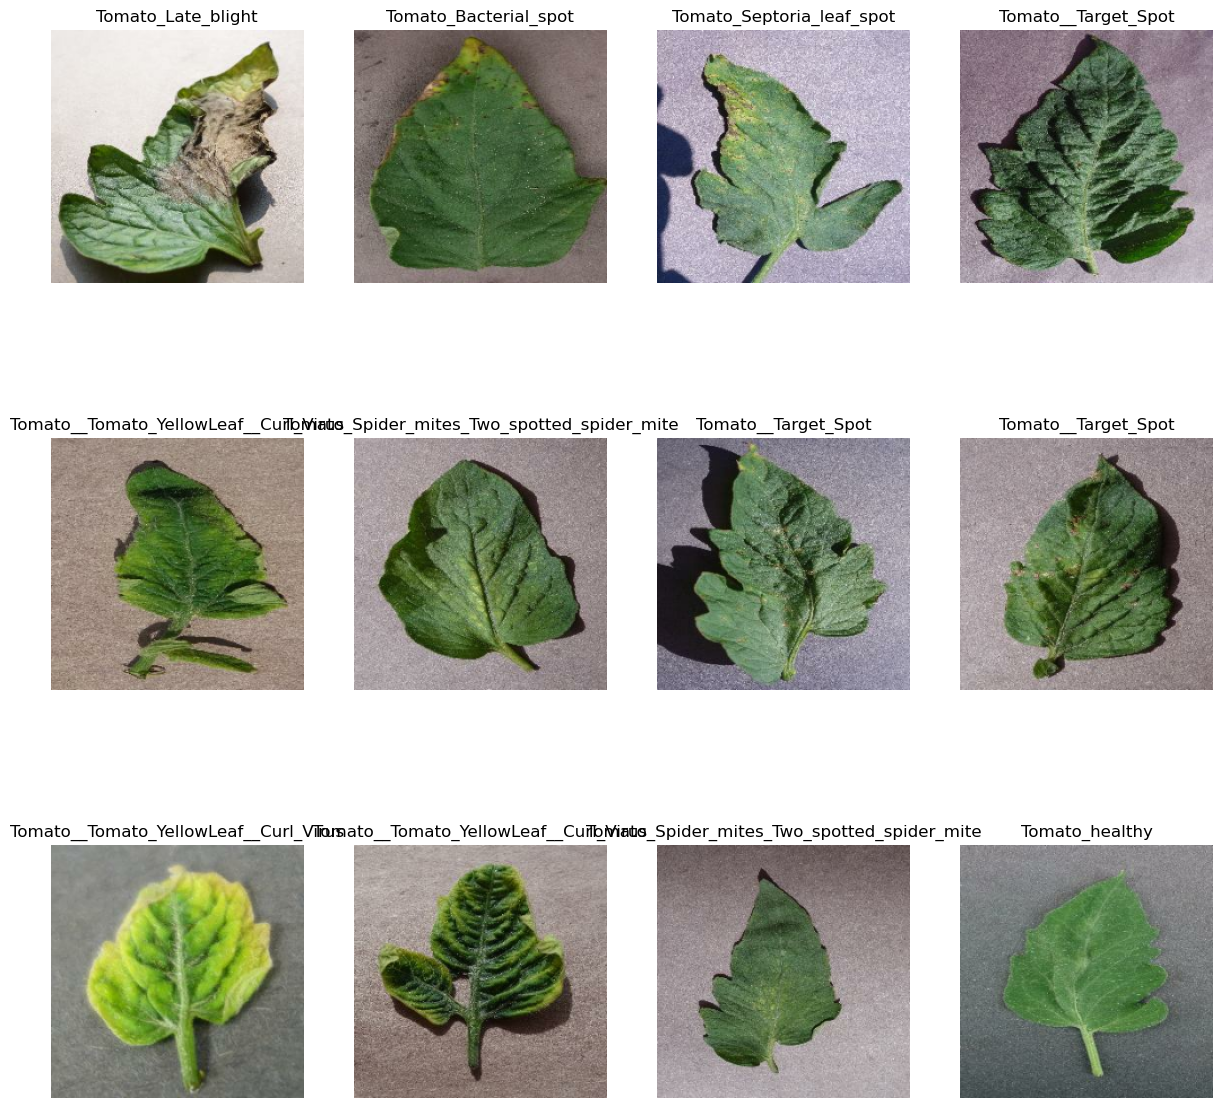

In [7]:
plt.figure(figsize=(15,15))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")

In [8]:
def get_dataset_partition_tf(ds , train_split=0.8 , val_split=0.1 , test_split=0.1 , shuffle=True , shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)
    
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds , val_ds , test_ds

In [9]:
train_ds , val_ds , test_ds = get_dataset_partition_tf(dataset)

In [10]:
len(train_ds)

400

In [11]:
 len(val_ds) 

50

In [12]:
len(test_ds)

51

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### MODEL DEFINING AND TRAINING

In [14]:
# RESIZING AN RESCALING
resize_and_rescale = tf.keras.Sequential([
    
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
])

In [16]:
CHANNELS=3

In [17]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=15

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [19]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')  # num_classes is the number of classes in your dataset
])

In [20]:
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (32, 1280)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (32, 256)                 327936    
                                                                 
 dropout (Dropout)           (32, 256)                

In [22]:
model.compile(
    
    optimizer='adam',
    
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    
    metrics=['accuracy']
)

In [23]:
EPOCHS=15

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
es_callback = EarlyStopping(
    
    monitor='val_loss' , min_delta = 0 , patience = 2 , verbose=0 , mode='auto' , baseline=None , restore_best_weights=False
)

In [25]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks= [es_callback],
    validation_data=val_ds
)

Epoch 1/15
400/400 [==============================] - 442s 1s/step - loss: 1.0104 - accuracy: 0.6611 - val_loss: 0.5794 - val_accuracy: 0.8144
Epoch 2/15
400/400 [==============================] - 367s 918ms/step - loss: 0.6752 - accuracy: 0.7685 - val_loss: 0.5002 - val_accuracy: 0.8356
Epoch 3/15
400/400 [==============================] - 342s 856ms/step - loss: 0.5981 - accuracy: 0.7939 - val_loss: 0.4930 - val_accuracy: 0.8269
Epoch 4/15
400/400 [==============================] - 338s 844ms/step - loss: 0.5594 - accuracy: 0.8054 - val_loss: 0.4394 - val_accuracy: 0.8356
Epoch 5/15
400/400 [==============================] - 335s 836ms/step - loss: 0.5247 - accuracy: 0.8192 - val_loss: 0.4520 - val_accuracy: 0.8338
Epoch 6/15
400/400 [==============================] - 340s 849ms/step - loss: 0.5064 - accuracy: 0.8216 - val_loss: 0.4248 - val_accuracy: 0.8525
Epoch 7/15
400/400 [==============================] - 344s 861ms/step - loss: 0.4976 - accuracy: 0.8291 - val_loss: 0.4670 - va

### EVALUATING MODEL 

In [26]:
scores=model.evaluate(test_ds)

51/51 [==============================] - 54s 653ms/step - loss: 0.3799 - accuracy: 0.8652


### RESULTS GRAPH 

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training VS Validation Losses')

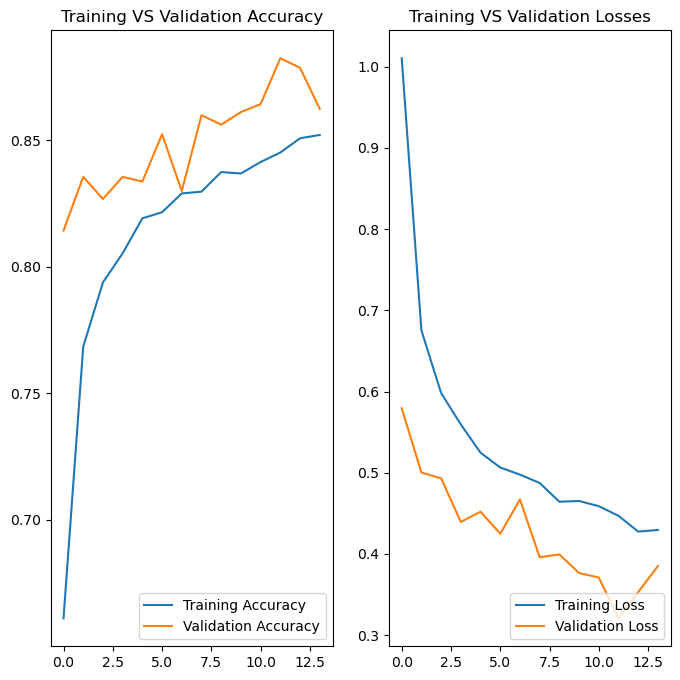

In [35]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot(range(14), acc , label='Training Accuracy')
plt.plot(range(14), val_acc , label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training VS Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(14), loss , label='Training Loss')
plt.plot(range(14), val_loss , label='Validation Loss')
plt.legend(loc='lower right')
plt.title("Training VS Validation Losses")

### TESTING MODEL 

Actual Label :  Tomato__Tomato_YellowLeaf__Curl_Virus
1/1 [==============================] - 2s 2s/step
Predicted Label :  Tomato__Tomato_YellowLeaf__Curl_Virus


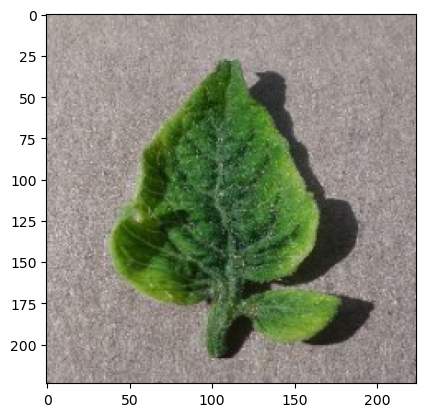

In [29]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    
    plt.imshow(first_image)
    
    print("Actual Label : ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label : ", class_names[np.argmax(batch_prediction[0])])
    
    

In [30]:
def predict(model , img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class , confidence

1/1 [==============================] - 0s 105ms/step


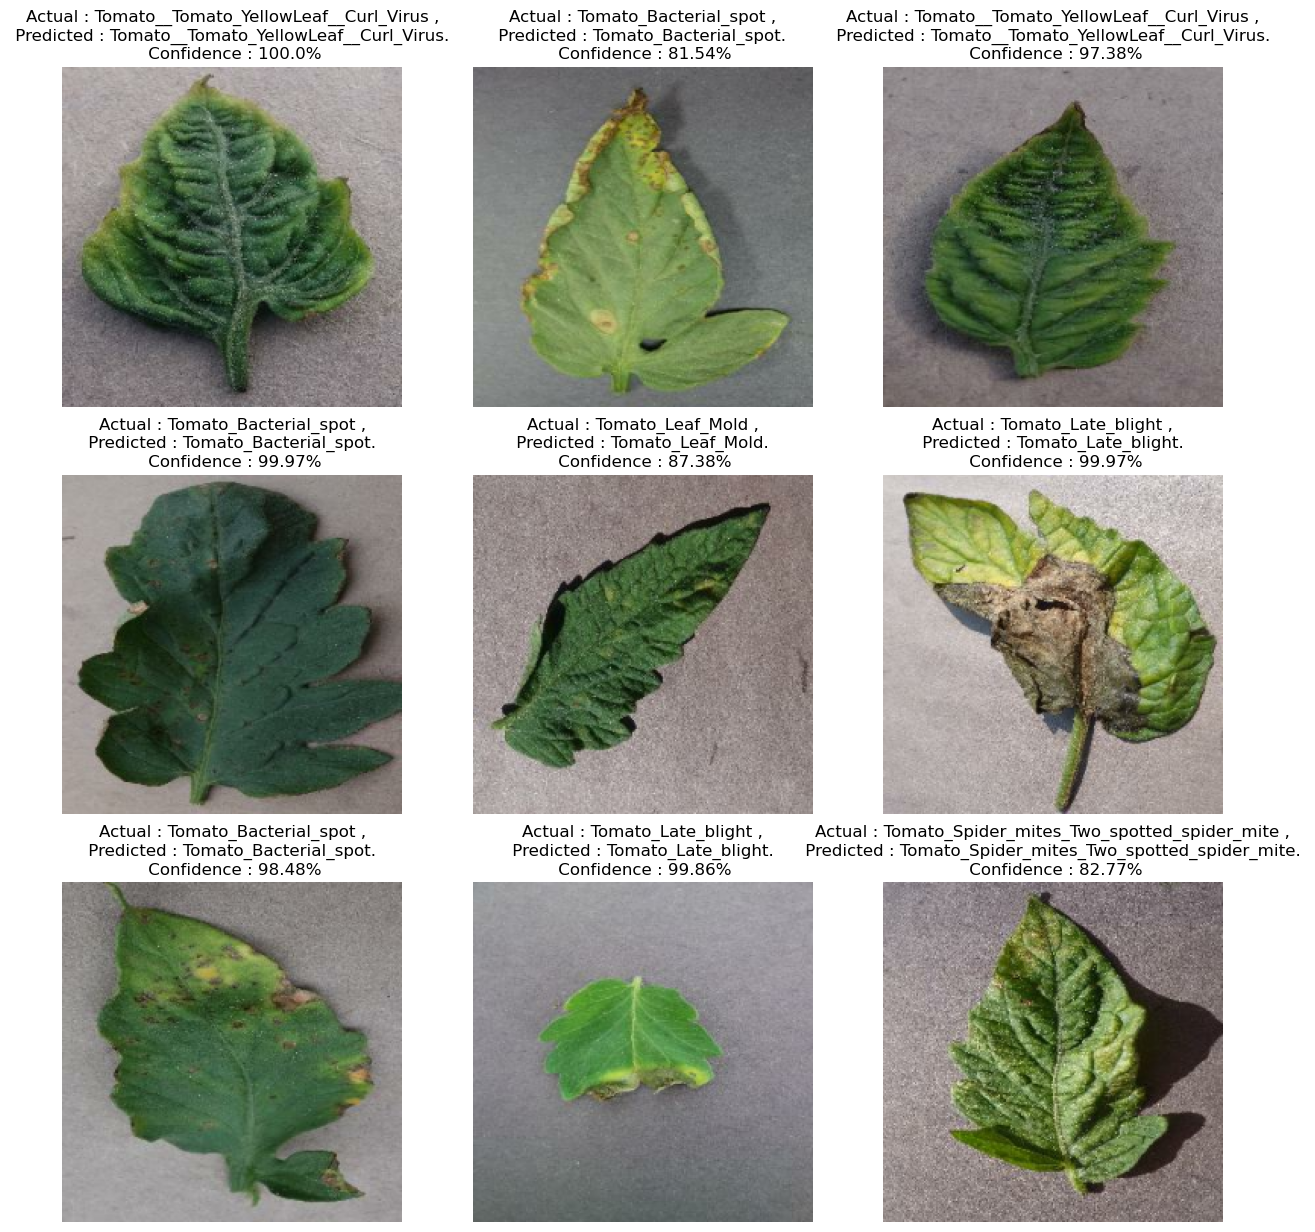

In [31]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence = predict(model , images[i].numpy())
        actual_class=class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class} ,\n Predicted : {predicted_class}. \n Confidence : {confidence}%")
        plt.axis("off")


### SAVING MODEL 

In [ ]:
#model.save("model.h5")